LIBRARY IMPORTS AT THE BEGINNING . 

In [293]:

import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import os
from plotly.subplots import make_subplots
from termcolor import colored
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm
import gc
import itertools


SOME USEFUL STYLES AND WARNINGS 

In [294]:
pio.templates.default = "simple_white"
antq_blue = "#336699"
antq_purple = "#ac39ac"
antq_red = "#e63900"
antq_orange = "#ff8c1a"
faded_grey = "#e6e6e6"
light_grey = "#d9d9d9"
heading_font = "Brush Script MT, Brush Script Std, cursive"
normal_font = "times new roman"
palette = px.colors.qualitative.Set2
palette_r = px.colors.qualitative.Set2_r
set1 = px.colors.qualitative.Set1
set3 = px.colors.qualitative.Set3
warnings.filterwarnings('ignore')

DATA SUMMARY - This is some of the data which will be used in this project .
dataset -> This is the main dataset which contains the information about the anime(movies and TV) .
Ratings_Dataset -> This contains the dataset which contains the information of rating of show given by each user .

In [295]:
dataset = pd.read_csv(r"Data\anime.csv")
dataset.head()
# this is returning me the data which is present in the dataset .       

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [296]:
Ratings_Dataset = pd.read_csv(r"Data\rating.csv")
Ratings_Dataset.head() 

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [297]:
dataset[dataset.name == 'Pokemon'] # this is how we can see an anime based on the name

,anime_id,name,genre,type,episodes,rating,members
1834,527,Pokemon,"Action, Adventure, Comedy, Fantasy, Kids",TV,276,7.43,229157


In [298]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


The Number of Enteries in the Datasets of Anime and Ratings are as follows: 

In [299]:
print(f'anime shape: {dataset.shape}\nrating shape: {Ratings_Dataset.shape}')

anime shape: (12294, 7)
rating shape: (7813737, 3)


Check the Missing Values

In [300]:
Ratings_Dataset.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [301]:
dataset.isna().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Now that we get the missing rows in both the datasets we can remove them as they are not useful for us .

REMOVING MISSING ROWS

In [302]:
dataset.dropna(axis=0 , inplace=True)
dataset.isna().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [303]:
dataset.describe()

,anime_id,rating,members
count,12017.000000,12017.000000,1.201700e+04
mean,13638.001165,6.478264,1.834888e+04
std,11231.076675,1.023857,5.537250e+04
min,1.000000,1.670000,1.200000e+01
25%,3391.000000,5.890000,2.250000e+02
50%,9959.000000,6.570000,1.552000e+03
75%,23729.000000,7.180000,9.588000e+03
max,34519.000000,10.000000,1.013917e+06


Now let see the episodes which are there in the various animes

In [304]:
dataset.episodes.value_counts()

episodes
1      5571
2      1075
12      810
13      571
26      514
       ... 
358       1
366       1
201       1
172       1
125       1
Name: count, Length: 187, dtype: int64

Now we remove the duplicates from the DATASET after checking for them .

In [305]:
number_of_duplicated_anime = dataset[dataset.duplicated()].shape[0] 
print(f"the number of duplicated anime are:{number_of_duplicated_anime}")

the number of duplicated anime are:0


In [306]:
number_of_duplicated_ratings = Ratings_Dataset[Ratings_Dataset.duplicated()].shape[0] 
print(f"the number of duplicated ratings are:{number_of_duplicated_ratings}")

the number of duplicated ratings are:1


In [307]:
Ratings_Dataset.drop_duplicates(keep='first', inplace=True)
number_of_duplicated_ratings = Ratings_Dataset[Ratings_Dataset.duplicated()].shape[0] 
print(f"the number of duplicated ratings are:{number_of_duplicated_ratings}")

the number of duplicated ratings are:0


CREATING THE DATABASE 

We can now create the merged dataset from these two csv files as follows :

In [308]:
final_dataset = pd.merge(dataset , Ratings_Dataset , on ="anime_id")
final_dataset.tail()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
7813605,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,39532,-1
7813606,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,48766,-1
7813607,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,60365,4
7813608,26081,Yasuji no Pornorama: Yacchimae!!,Hentai,Movie,1,5.46,142,27364,-1
7813609,26081,Yasuji no Pornorama: Yacchimae!!,Hentai,Movie,1,5.46,142,48766,-1


In [309]:
final_dataset.describe()

,anime_id,rating_x,members,user_id,rating_y
count,7.813610e+06,7.813610e+06,7.813610e+06,7.813610e+06,7.813610e+06
mean,8.908728e+03,7.653158e+00,1.786233e+05,3.672799e+04,6.144075e+00
std,8.883598e+03,6.729753e-01,1.881764e+05,2.099793e+04,3.727792e+00
min,1.000000e+00,1.670000e+00,2.900000e+01,1.000000e+00,-1.000000e+00
25%,1.240000e+03,7.270000e+00,4.403000e+04,1.897400e+04,6.000000e+00
50%,6.213000e+03,7.680000e+00,1.104700e+05,3.679100e+04,7.000000e+00
75%,1.409300e+04,8.130000e+00,2.442680e+05,5.475800e+04,9.000000e+00
max,3.451900e+04,9.500000e+00,1.013917e+06,7.351600e+04,1.000000e+01


NOW LETS START WITH THE DIFFERENT TYPES OF RECOMMENDATION SYSTEMS .

1. Popular based recommendation 

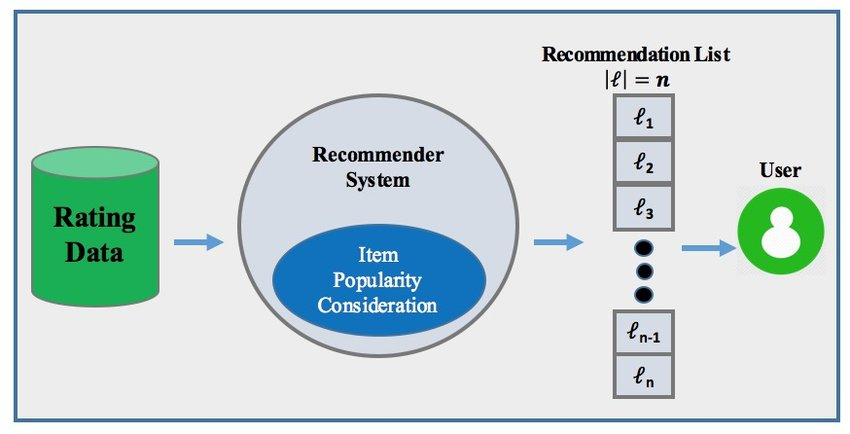

<font color = 'red'><u>Introduction</u></font>

For any machine learning problems, we need a baseline model or method to use as a reference whether our approach is good or not.Our machine learning prediction or sophsticated analysis should, at least, beat those baseline performance.For recommendation systems, a simple baseline could be recommending popular items to users. This baseline assumes that if an item is popular among many users, it's likely to be a good recommendation for new users as well. Thus , this is the simplest model for any recommendation system . 

<font color = 'red'><b>To define the popularity of the item</b></font>

Regarding the IMDB system , we use a metrics called the weighted rating system which is used to score the rating of each movie . 

The formulae for the same is :

Wr = (v / (v+m)) * R + (m / (v+m)) * C 

here , R = average rating of the show/movie 

v = total number of people's votes for the movie  

m = minimum votes required to be listed in the top 250(This number may vary as its defined by > 80 percentile of total votes) 

C = the average rating across the whole dataset   

<font color = 'red'><b>Disadvantages(Drawbacks)</b></font>

This method is not personalised for each user , each user gets the exact same result . 

<font color = 'red'><b>Use case </b></font>

For new users , if we dont know there liked shows and their favourite genres , we can provide them list based on ranking based on weighted_rating as this is the simplest model . 

This is how the streaming platforms work when we search by "popular" on them . 

<font color = 'red'><b>Refrence</b></font>

https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV?ref_=helpms_helpart_inline#

In [310]:
# Lets first do the pre-processing of the Ratings_Dataset to be used in this . 
def show_full_data(dataset, Ratings_Dataset):
  full_data_set = Ratings_Dataset.merge(dataset[['anime_id' , 'name']] , on = ['anime_id'] , how='left') # same as left joint 

  full_data_set = full_data_set.loc[:, ['anime_id' , 'name' , 'count_of_votes' , 'average_rating' , 'weighted_rating']]

  return full_data_set
  

def pre_prepocessing(Ratings_Dataset):
  Ratings_Dataset = Ratings_Dataset[Ratings_Dataset['rating'] != -1]
  Ratings_Dataset = Ratings_Dataset.groupby('anime_id' , as_index=False).agg({'user_id' : 'count' , 'rating' :'mean'})
  Ratings_Dataset.columns = ['anime_id','count_of_votes' ,'average_rating'] 

  return Ratings_Dataset

def weighted_rating(R,v,m,C):
  return (v/(v+m)) * R + (m/(v+m)) * C 

def find_popularity_based_ranking_score(dataset , Ratings_Dataset):
  Ratings_Dataset = pre_prepocessing(Ratings_Dataset)
  C = np.mean(Ratings_Dataset['average_rating'])
  m = np.percentile(Ratings_Dataset['count_of_votes'] , 80) 
  Ratings_Dataset = Ratings_Dataset[Ratings_Dataset['count_of_votes'] >= m]
  R = Ratings_Dataset['average_rating']
  v = Ratings_Dataset['count_of_votes']
  Ratings_Dataset['weighted_rating'] = weighted_rating(R,v,m,C)  # now this column will help to identify the weighted rating

  Ratings_Dataset = show_full_data(dataset , Ratings_Dataset)
  
  return Ratings_Dataset 



  

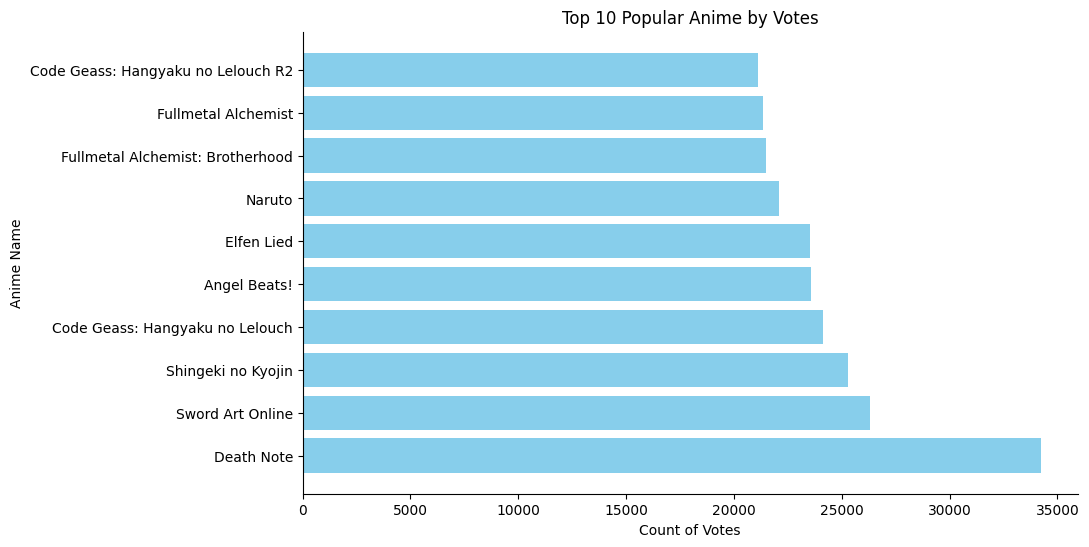

In [311]:
# this is the plot based on the number of votes count 

top_popular_anime = find_popularity_based_ranking_score(dataset , Ratings_Dataset)

top_popular_sorted = top_popular_anime.sort_values('count_of_votes', ascending=False).head(10)


names = top_popular_sorted['name']
votes = top_popular_sorted['count_of_votes']

plt.figure(figsize=(10, 6))
plt.barh(names, votes, color='skyblue')  
plt.xlabel('Count of Votes')
plt.ylabel('Anime Name')
plt.title('Top 10 Popular Anime by Votes')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

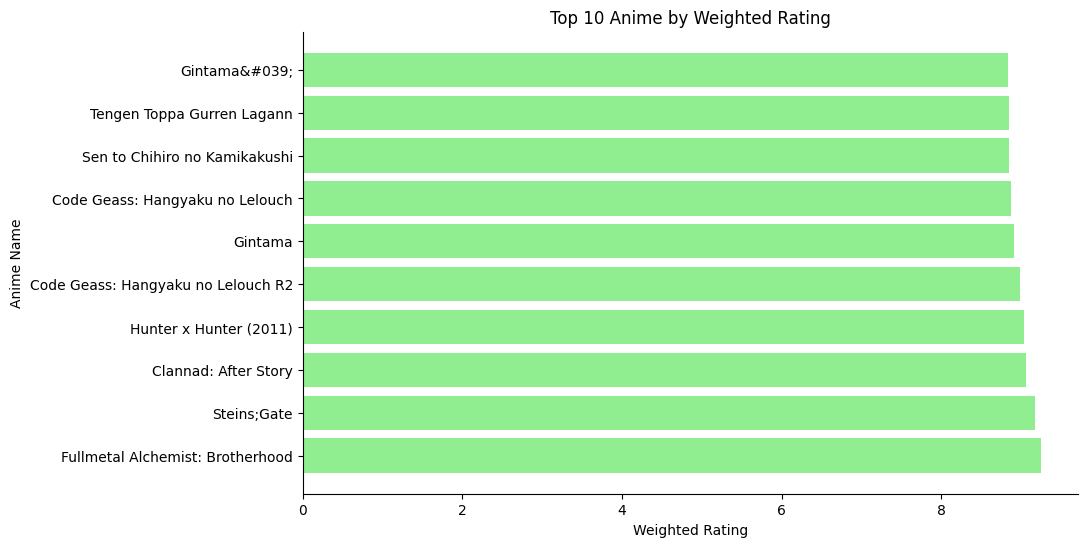

In [312]:

popular_sorted = top_popular_anime.sort_values('weighted_rating', ascending=False).head(10)


names = popular_sorted['name']
ratings = popular_sorted['weighted_rating']


plt.figure(figsize=(10, 6))
plt.barh(names, ratings, color='lightgreen')  
plt.xlabel('Weighted Rating')
plt.ylabel('Anime Name')
plt.title('Top 10 Anime by Weighted Rating')


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

Now , we will evaluate this on dataset , we are making train and the test set from the Rating_dataset , where points are choosen at random .

<font color = 'red'><b>EVALUATION</b></font>


In [313]:
def make_datasets(Ratings_Dataset):
  Ratings_Dataset = Ratings_Dataset[Ratings_Dataset['rating'] >=0].copy()
  Ratings_Dataset = Ratings_Dataset.sample(frac=1 ,random_state=42)  
  split_index = int(0.9*len(Ratings_Dataset))
  train = Ratings_Dataset.iloc[:split_index]
  test = Ratings_Dataset.iloc[split_index:]

  print(train.shape)
  print(test.shape) 

  return train , test  


train , test = make_datasets(Ratings_Dataset)  # we are diving the original dataset into train and test in the ratio 9:1


(5703516, 3)
(633724, 3)


In [314]:
import math

def precision_at_k(actual, predicted, k, col_item):
    predicted_sorted = predicted.sort_values('anime_id', ascending=False).head(k)
    recommended_items = set(predicted_sorted[col_item])
    relevant_items = set(actual[col_item])
    precision = len(recommended_items.intersection(relevant_items)) / k if k > 0 else 0
    return precision

def recall_at_k(actual, predicted, k, col_item):
    predicted_sorted = predicted.sort_values('anime_id', ascending=False).head(k)
    recommended_items = set(predicted_sorted[col_item])
    relevant_items = set(actual[col_item])
    recall = len(recommended_items.intersection(relevant_items)) / len(relevant_items) if len(relevant_items) > 0 else 0
    return recall

def map_at_k(actual, predicted, k, col_item):
    map_value = 0
    num_hits = 0
    predicted_sorted = predicted.sort_values('anime_id', ascending=False).head(k)

    for i, item in enumerate(predicted_sorted[col_item], 1):
        if item in set(actual[col_item]):
            num_hits += 1
            map_value += num_hits / i  

    map_value /= min(k, len(actual)) if len(actual) > 0 else 1
    return map_value

def ndcg_at_k(actual, predicted, k, col_item):
    def dcg_at_k(scores, k):
        return sum([(2 ** score - 1) / (math.log(i + 2, 2)) for i, score in enumerate(scores[:k])])

    predicted_sorted = predicted.sort_values('anime_id', ascending=False).head(k)
    rel_scores = [1 if item in set(actual[col_item]) else 0 for item in predicted_sorted[col_item]]
    dcg = dcg_at_k(rel_scores, k)
    ideal_dcg = dcg_at_k(sorted(rel_scores, reverse=True), k)
    ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0
    return ndcg


def evaluation_metrics(train,test,ROW_PRED , k):
  # first select the top-k recommendations based on the ROW_PRED
  popular_anime = find_popularity_based_ranking_score(dataset , train) 
  popular_sorted = popular_anime.sort_values(ROW_PRED , ascending = False)[['anime_id' , ROW_PRED]].reset_index(drop=True).copy()
  popular_sorted = popular_sorted.head(k) 

  # now lets prepare the predictions for the evaluation 
  test_users = test['user_id'].unique()
  user_product_list = list(itertools.product(test_users , popular_sorted['anime_id']))
  user_product = pd.DataFrame(user_product_list, columns=['user_id' , 'anime_id'])

  print('Number of unique user-product pairs are :' + str(len(user_product)))

  # remove the animes which have already appeared on the test set 
  users_product_filtered = user_product[user_product['user_id'].isin(train['user_id']) & user_product['anime_id'].isin(train['anime_id'])]

  print('Number of user_product pairs after removing seen animes: ' +  str(len(users_product_filtered)))

  total_data = pd.merge(popular_sorted , users_product_filtered , on=['anime_id'] , how = 'inner') 
  
  data_columns = {
        'col_item': 'anime_id',
        }
  data_columns['ROW_PRED'] = ROW_PRED
  
  # now we use a couple of facters like map_at_k , ndcg_at_k , precision_at_k and recall_at_k to give a good evaluation result . 

  map_eval = map_at_k(test , total_data , k=k , col_item='anime_id')
  ndcg_eval = ndcg_at_k(test ,total_data , k=k , col_item='anime_id')
  precision_eval = precision_at_k(test , total_data , k =k , col_item='anime_id')
  recall_eval = recall_at_k(test , total_data , k = k , col_item='anime_id')

  print(f"MAP: {map_eval:.4f}\nNDCG@{k}: {ndcg_eval:.4f}\nPRECISION@{k}: {precision_eval:.4f}\nRECALL@{k}: {recall_eval:.4f}")
  print("----------------------------------------------------------------------------------")


evaluation_metrics(train , test , ROW_PRED='count_of_votes' , k =3)
evaluation_metrics(train , test , ROW_PRED='weighted_rating' , k = 3)


# thus this is how we can create the evaluation for this

Number of unique user-product pairs are :171945
Number of user_product pairs after removing seen animes: 170838
MAP: 1.0000
NDCG@3: 1.0000
PRECISION@3: 0.3333
RECALL@3: 0.0001
----------------------------------------------------------------------------------
Number of unique user-product pairs are :171945
Number of user_product pairs after removing seen animes: 170838
MAP: 1.0000
NDCG@3: 1.0000
PRECISION@3: 0.3333
RECALL@3: 0.0001
----------------------------------------------------------------------------------


2.Content-based recommendation 
